# Procesamiento de lenguaje natural
## Tokenización por palabras
### Nombre: Eduardo Echeverria
### Cohorte: 15Co2024

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

In [1]:
import bs4 as bs
import io
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import pickle
import random
import re
import seaborn as sns
import urllib.request

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout, Embedding, GRU, LSTM, SimpleRNN
from keras.optimizers import Adam
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## DataSet

Se utilizará para este desafio, el texto correspondiente al cuento "Corazón Delator" de Edgar Allan Poe obtenido del sitio web "https://www.textos.info".
Se trata de un texto con una longitud mayor a la de los textos vistos en clases.

In [2]:
raw_html = urllib.request.urlopen('https://www.textos.info/edgar-allan-poe/el-corazon-delator/ebook')
raw_html = raw_html.read()

# Realizamos el parseo del articulo
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontramos todos los párrafos del HTML (bajo el tag <p>)
article_paragraphs = article_html.find_all('p')

article_text = ''

for paragraph in article_paragraphs:
    article_text += paragraph.text + ' '

# Pasamos todo el texto a minúscula
article_text = article_text.lower()

# Eliminamos los salotos de linea
article_text = article_text.replace('\n', ' ')
article_text = article_text.replace('\r', ' ')

In [3]:
article_text[:1000]

' ¡es verdad! nervioso, muy, muy terriblemente nervioso yo había sido y   soy; ¿pero por qué dirán ustedes que soy loco? la enfermedad había   aguzado mis sentidos, no destruido, no entorpecido. sobre todo estaba la   penetrante capacidad de oír. yo oí todas las cosas en el cielo y en la   tierra. yo oí muchas cosas en el infierno. ¿cómo entonces soy yo loco?   ¡escuchen! y observen cuan razonablemente, cuan serenamente, puedo   contarles toda la historia. es imposible decir cómo primero la idea entró en mi cerebro, pero,   una vez concebida, me acosó día y noche. objeto no había ninguno. pasión   no había ninguna. yo amé al viejo. el nunca me había hecho mal. él no   me había insultado. de su oro no tuve ningún deseo. ¡creo que fue su ojo! sí, ¡fue eso!   uno de sus ojos parecía como el de un buitre — un ojo azul pálido con   una nube encima. cada vez que caía sobre mí, la sangre se me helaba, y entonces de a   poco, muy gradualmente, me decidí a tomar la vida del viejo, y así   libra

In [4]:
# Segmentamos el texto original en oraciones
sentences = sent_tokenize(article_text, language='spanish')

sentences[:10]

[' ¡es verdad!',
 'nervioso, muy, muy terriblemente nervioso yo había sido y   soy; ¿pero por qué dirán ustedes que soy loco?',
 'la enfermedad había   aguzado mis sentidos, no destruido, no entorpecido.',
 'sobre todo estaba la   penetrante capacidad de oír.',
 'yo oí todas las cosas en el cielo y en la   tierra.',
 'yo oí muchas cosas en el infierno.',
 '¿cómo entonces soy yo loco?',
 '¡escuchen!',
 'y observen cuan razonablemente, cuan serenamente, puedo   contarles toda la historia.',
 'es imposible decir cómo primero la idea entró en mi cerebro, pero,   una vez concebida, me acosó día y noche.']

Se procede a realizar una breve limpieza del texto con el objetivo de eliminar caracteres especiales como signos de interrogación, admiración, guiones, etc.

In [32]:
# Para simplificar el texto, eliminamos caracteres especiales
only_letter_sentences = [re.sub(r'[^\w\s]', ' ', sentence) for sentence in sentences]

# Se reemplazan espacios consecutivos por un único espacio
fixed_sentences = [re.sub(r'\s+', ' ', sentence).strip() for sentence in only_letter_sentences]

fixed_sentences[:10]

['es verdad',
 'nervioso muy muy terriblemente nervioso yo había sido y soy pero por qué dirán ustedes que soy loco',
 'la enfermedad había aguzado mis sentidos no destruido no entorpecido',
 'sobre todo estaba la penetrante capacidad de oír',
 'yo oí todas las cosas en el cielo y en la tierra',
 'yo oí muchas cosas en el infierno',
 'cómo entonces soy yo loco',
 'escuchen',
 'y observen cuan razonablemente cuan serenamente puedo contarles toda la historia',
 'es imposible decir cómo primero la idea entró en mi cerebro pero una vez concebida me acosó día y noche']

## Elección del tamaño del contexto

In [33]:
# Procedemos a segmentar el texto
segmented_sentences = [text_to_word_sequence(sentence) for sentence in fixed_sentences]

In [34]:
# Comparamos el texto inicial...
fixed_sentences[50]

'en un momento oí un suave gemido y supe que era el gemido del terror mortal'

In [35]:
# Con el texto segmentado
segmented_sentences[50]

['en',
 'un',
 'momento',
 'oí',
 'un',
 'suave',
 'gemido',
 'y',
 'supe',
 'que',
 'era',
 'el',
 'gemido',
 'del',
 'terror',
 'mortal']

(array([25., 25., 34., 16., 11., 18.,  8., 11.,  6.,  2.,  5.,  4.,  1.,
         3.,  1.,  2.,  2.,  1.,  0.,  2.]),
 array([ 1. ,  3.4,  5.8,  8.2, 10.6, 13. , 15.4, 17.8, 20.2, 22.6, 25. ,
        27.4, 29.8, 32.2, 34.6, 37. , 39.4, 41.8, 44.2, 46.6, 49. ]),
 <BarContainer object of 20 artists>)

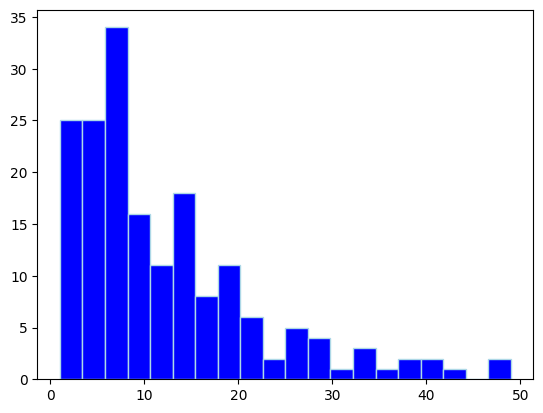

In [36]:
# Calculamos la longitud de cada oracion
sentence_length = [len(segmented_sentence) for segmented_sentence in segmented_sentences]

# Desplegamos la distribucion de las longitudes de linea
plt.hist(sentence_length, bins=20, color="blue", edgecolor="lightblue")


In [37]:
# A partir de la distribucion de longitudes de cada linea de texto, elegimos un percentil de 90%
# como criterio para determinar el maximo tamaño del contexto.
max_context_size = int(np.percentile(sentence_length, 90)-1)
print(f"Tamaño de contexto: {max_context_size}")

Tamaño de contexto: 25


## Tokenización

Se procede a realizar la tokenizacion de las oraciones (sentences) del texto para asignarle un número a cada palabra.

In [38]:
# Instanciamos el tokenizador
tok = Tokenizer()
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a numeros
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [39]:
# Tomamos una linea segmentada como ejemplo
print(segmented_sentences[50])

# Desplegamos la misma linea tokenizada
print(tokenized_sentences[50])

['en', 'un', 'momento', 'oí', 'un', 'suave', 'gemido', 'y', 'supe', 'que', 'era', 'el', 'gemido', 'del', 'terror', 'mortal']
[6, 7, 78, 81, 7, 409, 130, 3, 410, 5, 33, 2, 130, 20, 131, 411]


## Estructuración de los DataSets de Entrenamiento y Validación

Partiendo de la variable "tokenized_lines" vamos a armar los datasets de entrenamiento y validación.

In [40]:
tokenized_sent_train, tokenized_sent_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a separar las oraciones que tienen un tamaño menor al contexto máximo, para generarnos más secuencias de entrenamiento

In [41]:
tok_sentences = []

for sentence in tokenized_sent_train:
    if len(sentence) > (max_context_size + 1):
        extra = len(sentence) - (max_context_size + 1) + 1
        for i in range (extra):
            tok_sentences.append(sentence[i:i + max_context_size + 1])
    else:
        tok_sentences.append(sentence)

In [42]:
len(tok_sentences)

224

Realizamos la aumentación de los datos

In [43]:
tok_sentences_augmented = []

for sent in tok_sentences:
    subsequence = [sent[:i + 2] for i in range(len(sent) - 1)]
    tok_sentences_augmented.append(pad_sequences(subsequence, maxlen=max_context_size + 1, padding='pre'))

In [44]:
# Concatenamos todas las secuencias en un array único
train_sequence = np.concatenate(tok_sentences_augmented, axis=0)

In [45]:
train_sequence.shape

(3475, 26)

In [46]:
# Definimos las entradas y los targets
X = train_sequence[:,:-1]
y = train_sequence[:,1:]

In [47]:
y.shape

(3475, 25)

In [48]:
tok.index_word

{1: 'la',
 2: 'el',
 3: 'y',
 4: 'de',
 5: 'que',
 6: 'en',
 7: 'un',
 8: 'no',
 9: 'más',
 10: 'había',
 11: 'me',
 12: 'a',
 13: 'con',
 14: 'se',
 15: 'pero',
 16: 'yo',
 17: 'lo',
 18: 'mi',
 19: 'como',
 20: 'del',
 21: 'para',
 22: 'los',
 23: 'las',
 24: 'una',
 25: 'sobre',
 26: 'viejo',
 27: 'por',
 28: 'su',
 29: 'fuerte',
 30: 'muy',
 31: 'noche',
 32: 'al',
 33: 'era',
 34: 'él',
 35: 'cuando',
 36: 'bien',
 37: 'es',
 38: 'qué',
 39: 'estaba',
 40: 'ojo',
 41: 'mis',
 42: 'entonces',
 43: 'tan',
 44: 'ustedes',
 45: 'todo',
 46: 'ahora',
 47: 'cabeza',
 48: 'sonido',
 49: 'corazón',
 50: 'ellos',
 51: 'sido',
 52: 'nada',
 53: 'cama',
 54: 'cuarto',
 55: 'ruido',
 56: 'vez',
 57: 'sí',
 58: 'cada',
 59: 'así',
 60: 'linterna',
 61: 'ver',
 62: 'ya',
 63: 'mientras',
 64: 'podía',
 65: 'sin',
 66: 'soy',
 67: 'loco',
 68: 'fue',
 69: 'puerta',
 70: 'oh',
 71: 'hora',
 72: 'dentro',
 73: 'hacer',
 74: 'esto',
 75: 'ni',
 76: 'o',
 77: 'constantemente',
 78: 'momento',
 79: '

In [49]:
# Cantidad de plabras en el vocabulario
vocabulary_size = len(tok.word_counts)

print(f"Cantidad de palabras en el vocabulario:\n{vocabulary_size}")
print(f"Indice para cada palabra:\n{tok.word_index}")
print(f"Recurrencia de las palabras:\n{tok.word_docs}")

Cantidad de palabras en el vocabulario:
762
Indice para cada palabra:
{'la': 1, 'el': 2, 'y': 3, 'de': 4, 'que': 5, 'en': 6, 'un': 7, 'no': 8, 'más': 9, 'había': 10, 'me': 11, 'a': 12, 'con': 13, 'se': 14, 'pero': 15, 'yo': 16, 'lo': 17, 'mi': 18, 'como': 19, 'del': 20, 'para': 21, 'los': 22, 'las': 23, 'una': 24, 'sobre': 25, 'viejo': 26, 'por': 27, 'su': 28, 'fuerte': 29, 'muy': 30, 'noche': 31, 'al': 32, 'era': 33, 'él': 34, 'cuando': 35, 'bien': 36, 'es': 37, 'qué': 38, 'estaba': 39, 'ojo': 40, 'mis': 41, 'entonces': 42, 'tan': 43, 'ustedes': 44, 'todo': 45, 'ahora': 46, 'cabeza': 47, 'sonido': 48, 'corazón': 49, 'ellos': 50, 'sido': 51, 'nada': 52, 'cama': 53, 'cuarto': 54, 'ruido': 55, 'vez': 56, 'sí': 57, 'cada': 58, 'así': 59, 'linterna': 60, 'ver': 61, 'ya': 62, 'mientras': 63, 'podía': 64, 'sin': 65, 'soy': 66, 'loco': 67, 'fue': 68, 'puerta': 69, 'oh': 70, 'hora': 71, 'dentro': 72, 'hacer': 73, 'esto': 74, 'ni': 75, 'o': 76, 'constantemente': 77, 'momento': 78, 'les': 79, 'a

## Definición del Modelo

Se probaran tres tipos de arquitecturas:
- LSTM, tal cual fue demostrada en clase.
- SimpleRNN
- GRU (Gated Recurrent Unit)

### Primer Modelo
LSTM

In [52]:
model_LSTM = Sequential()

# Capa de Embedding
model_LSTM.add(Embedding(input_dim = vocabulary_size + 1, output_dim = 50, input_shape = (None,)))

# Primera capa LSTM
model_LSTM.add(LSTM(100, return_sequences = True))
model_LSTM.add(Dropout(0.2))

# Segunda capa LSTM
model_LSTM.add(LSTM(100, return_sequences = True))
model_LSTM.add(Dropout(0.2))

# Capa de salida con activacion Softmax
model_LSTM.add(Dense(vocabulary_size + 1, activation = 'softmax'))

# Clasificación Sparse_categorical_crossentropy con optimizador RMSProp
model_LSTM.compile(loss = SparseCategoricalCrossentropy(), optimizer = 'rmsprop')

model_LSTM.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, None, 50)            │          38,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 763)           │          77,063 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256,013 (1000.05 KB)

 Trainable params: 256,013 (1000.05 KB)

 Non-trainable params: 0 (0.00 B)

### Segundo Modelo
SimpleRNN

In [51]:
model_simpleRNN = Sequential()

# Capa de Embedding
model_simpleRNN.add(Embedding(input_dim = vocabulary_size + 1, output_dim = 50, input_shape = (None,)))

# Primera capa SimpleRNN
model_simpleRNN.add(SimpleRNN(100, return_sequences = True))
model_simpleRNN.add(Dropout(0.2))

# Segunda capa SimpleRNN
model_simpleRNN.add(SimpleRNN(100, return_sequences = True))
# model_simpleRNN.add(Dropout(0.2))

# Capa de salida con activacion con softmax
model_simpleRNN.add(Dense(vocabulary_size + 1, activation='softmax'))

# Clasificación Sparse_categorical_crossentropy. Optimizador RMSProp
model_simpleRNN.compile(loss = SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_simpleRNN.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 50)            │          38,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, None, 100)           │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, None, 100)           │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 763)           │          77,063 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,413 (587.55 KB)

 Trainable params: 150,413 (587.55 KB)

 Non-trainable params: 0 (0.00 B)

### Tercer modelo
GRU

In [53]:
model_GRU = Sequential()

# Capa de Embedding
model_GRU.add(Embedding(input_dim = vocabulary_size + 1, output_dim = 50, input_shape = (None,)))

# Primera capa GRU
model_GRU.add(GRU(100, return_sequences = True))
model_GRU.add(Dropout(0.2))

# Segunda capa GRU
model_GRU.add(GRU(100, return_sequences = True))
model_GRU.add(Dropout(0.2))

# Capa de salida con activacion con softmax
model_GRU.add(Dense(vocabulary_size + 1, activation = 'softmax'))

# Clasificacion Sparse_categorical_crossentropy. Optimizador RMSProp
model_GRU.compile(loss = SparseCategoricalCrossentropy(), optimizer = 'rmsprop')

model_GRU.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, None, 50)            │          38,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, None, 100)           │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, None, 100)           │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, None, 763)           │          77,063 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,413 (864.89 KB)

 Trainable params: 221,413 (864.89 KB)

 Non-trainable params: 0 (0.00 B)

Utilizamos la Clase "PplCallback" para el calculo de la Perplejidad a medida que avanzan los entrenamientos.

In [64]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=15):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.model_name = model_name
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):
        scores = []
        batch_size = 32  # Tamaño del lote para las predicciones

        # Se realizan predicciones por lotes para el cálculo de la perplejidad
        for start_idx, (start, end) in enumerate(self.info):

            # Se selecciona el lote de secuencias correspondiente
            batch_padded = self.padded[start:end]
            num_batches = int(np.ceil(len(batch_padded) / batch_size))

            # Se calculan las probabilidades para cada lote
            probs = []
            for i in range(num_batches):
                batch_start = i * batch_size
                batch_end = min((i + 1) * batch_size, len(batch_padded))
                batch_predictions = self.model.predict(batch_padded[batch_start:batch_end], verbose=0)

                # Se recopilan las probabilidades para los términos target
                for idx_seq, idx_vocab in zip(range(batch_start, batch_end), self.target[start:end]):
                    probs.append(batch_predictions[idx_seq - batch_start, -1, idx_vocab])

            # Se calcula la perplejidad para la secuencia actual
            scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))

            # Se limpian variables para liberar memoria
            del batch_padded, batch_predictions, probs

        # Se promedian todos los scores
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # Se verifica si se debe detener el entrenamiento
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save(f'{self.model_name}.keras')
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True


## Entrenamiento

En este punto se realiza el entrenamiento de los modelos propuestos. Cabe mencionar que se probaron varias arquitecturas, con diferentes parámetros y tamaños de Embeddings.

Tambien se probaron distintos tipos de optimizadores como RMSProp y Adam. Sin embargo loe mejores resultados se obtuvieron con RMSProp.

En general, luego de haber probado con diferentes variaciones, se observa que los resultados no son del todo los esperados, dado que los valores de perplejidad no descienden de la manera esperada, lo cual indica que el modelo aún continua teniendo problemas con el texto.

In [65]:
history_ppl_LSTM = []
hist_LSTM = model_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sent_val, history_ppl_LSTM, model_name='model_LSTM')], batch_size=64)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 1.9751
 mean perplexity: 8944.997854249239 

Saved new model!
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - loss: 1.9750
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.8931
 mean perplexity: 6868.807311110017 

Saved new model!
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - loss: 1.8931
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1.8214
 mean perplexity: 5935.936116806385 

Saved new model!
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - loss: 1.8214
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 1.7579
 mean perplexity: 6532.433122354949 

55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - loss: 1.7578
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 1.6995
 mean perplexity: 5798.342163279373 

Saved new model!
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - loss: 1.6993
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.6425
 mean perplexity: 7320.971045308661 

55/55 ━━━━━━━━━━━

In [66]:
history_ppl_simpleRNN = []
hist_simpleRNN = model_simpleRNN.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sent_val, history_ppl_simpleRNN, model_name='model_simpleRNN')], batch_size=64)

Epoch 1/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.6607
 mean perplexity: 12838.416407330007 

Saved new model!
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - loss: 0.6602
Epoch 2/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6129
 mean perplexity: 10107.800889629783 

Saved new model!
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - loss: 0.6126
Epoch 3/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5799
 mean perplexity: 13024.902456048894 

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 0.5797
Epoch 4/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.5480
 mean perplexity: 14911.190287461666 

55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - loss: 0.5479
Epoch 5/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.5276
 mean perplexity: 12421.664348354865 

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.5274
Epoch 6/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.5011
 mean perplexity: 12062.797590393297 

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss

In [67]:
history_ppl_GRU= []
hist_GRU = model_GRU.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sent_val, history_ppl_GRU, model_name='model_GRU')], batch_size=64)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 1.3120
 mean perplexity: 13198.709566679541 

Saved new model!
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - loss: 1.3119
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.2431
 mean perplexity: 18277.54620129798 

55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - loss: 1.2431
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 1.2044
 mean perplexity: 18512.324289282446 

55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - loss: 1.2042
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 1.1500
 mean perplexity: 13947.043655822814 

55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 275ms/step - loss: 1.1498
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 1.1072
 mean perplexity: 18471.855690652403 

55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - loss: 1.1070
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 1.0678
 mean perplexity: 16970.894313006283 

55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - loss: 1.0677
Epoch 

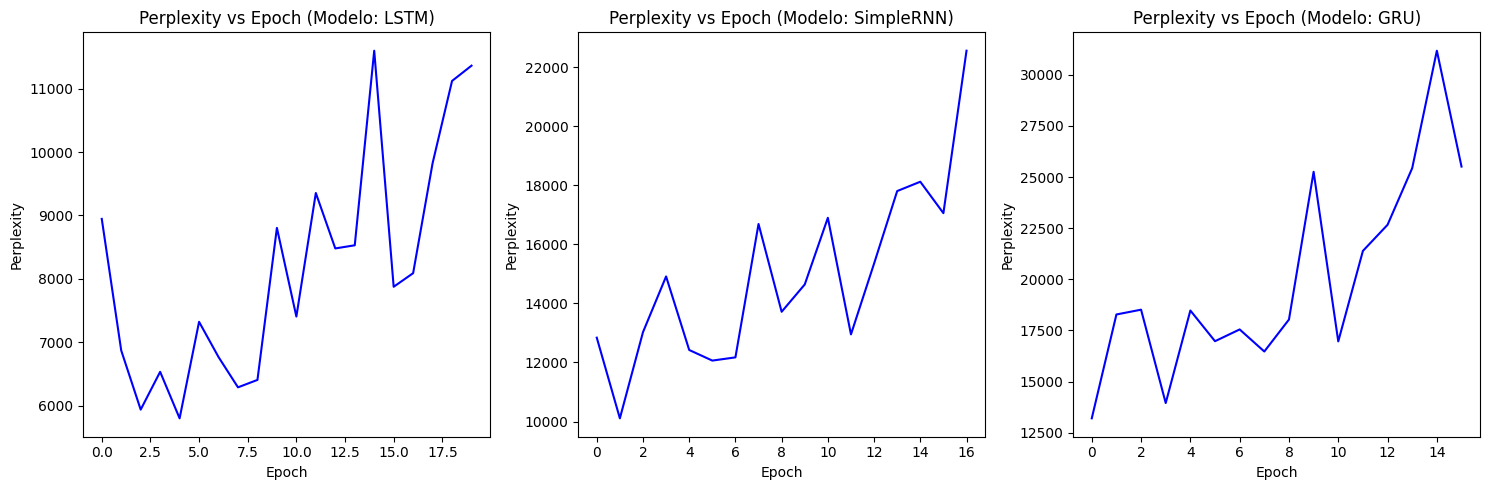

In [68]:
# Creamos subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Para el modelo LSTM
axs[0].plot(history_ppl_LSTM, color='blue')
axs[0].set_title('Perplexity vs Epoch (Modelo: LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Perplexity')

# Para el modelo SimpleRNN
axs[1].plot(history_ppl_simpleRNN, color='blue')
axs[1].set_title('Perplexity vs Epoch (Modelo: SimpleRNN)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')

# Para el modelo GRU
axs[2].plot(history_ppl_GRU, color='blue')
axs[2].set_title('Perplexity vs Epoch (Modelo: GRU)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Perplexity')

plt.tight_layout()
plt.show()

En los gráficos anteriores  se observa que en general la perplejidad no baja de acuerdo a lo esperado. En general, el mejor rendimiento se obtiene con el modelo LSTM, donde si bien, la perplejidad sube también se observa que en ciertos momentos se presentan descenso.

El peor escenario se presenta con el modelo GRU donde los valores de perplejidad ascienden bastane, al margen del comportamiento irregular de las mediciones obtenidas.

In [70]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_simpleRNN = keras.models.load_model('model_simpleRNN.keras')
model_GRU = keras.models.load_model('model_GRU.keras')

## Predicción de Próxima Palabra

A continuación se utiliza la librería Gradio para obtener las predicciones mediante una interfaz gráfica.

In [71]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/13

In [72]:
import gradio as gr

def model_response(input_text, model=model_LSTM):
    encoded = tok.texts_to_sequences([input_text])[0]
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')
    y_pred = np.argmax(model.predict(encoded)[0,-1,:])

    output_word = ""
    for word, index in tok.word_index.items():
        if index == y_pred:
            output_word = word
            break

    return f"{input_text} {output_word}"

interface = gr.Interface(fn=model_response, inputs=["textbox"], outputs="text")
interface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f100dde8e55e048190.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f100dde8e55e048190.gradio.live


In [73]:
print(f'Respuesta LSTM: { model_response("Los oficiales estaban", model_LSTM) }')
print(f'Respuesta SimpleRNN: {model_response("Los oficiales estaban", model_simpleRNN)}')
print(f'Respuesta GRU: {model_response("Los oficiales estaban", model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Respuesta LSTM: Los oficiales estaban de
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Respuesta SimpleRNN: Los oficiales estaban haber
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Respuesta GRU: Los oficiales estaban más


Se observa en general resultados mas comprensibles con los modelos LSTM y GRU. En correspondencia con la irregularidad observada en las mediciones de perplejidad, el resultado obtenido para el modelo SimpleRNN es el que presenta un texto menos comprensible

## Generacion de Secuencias

A continuación se analiza la generación de secuencias para los tres modelos entrenados

In [74]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    output_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([output_text])[0]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        y_pred = np.argmax(model.predict(encoded)[0,-1,:])

        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_pred:
                output_word = word
                break

		  # Agrego las palabras a la frase predicha
        output_text += f"  {output_word}"

    return output_text

In [75]:
input_text='Llevé a mis visitantes'

print('Modelo LSTM:')
print(generate_seq(model_LSTM, tok, input_text, max_length=max_context_size, n_words=10))

print('Modelo Simple RNN:')
print(generate_seq(model_simpleRNN, tok, input_text, max_length=max_context_size, n_words=10))

print('Modelo GRU:')
print(generate_seq(model_GRU, tok, input_text, max_length=max_context_size, n_words=10))

Modelo LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Llevé a mis visitantes  de  y  que  cabeza  ponía  una  oscura  oscura  muy  sorda
Modelo Simple RNN:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Llevé a mis visitantes  a  de  sus  fatigas  mientras  yo  mismo  con  la  osadía
Modelo GRU:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56m

Si bien se observa que pequeñas secciones de cada oración presentan algo de coherencia ("...mientras yo mismo") en general las oraciones generadas por cada modelo no tienen mucho sentido. Se observó que ajustando algunos parámetros, es posible mejorar las secuencias obteniendo mayor variedad de palabras.

## Beam Search y Muestreo Aleatorio

In [76]:
def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [77]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [78]:
lstm_sto_beamsearch = beam_search(model_LSTM, num_beams=10, num_words=5, input="Lo primero que hice fue", temp=5, mode="sto")
print(f"model_LSTM (estocastico), temp=5: {decode(lstm_sto_beamsearch[0])}")

rnn_sto_beamsearch = beam_search(model_simpleRNN, num_beams=10, num_words=5, input="Lo primero que hice fue", temp=5, mode="sto")
print(f"model_simpleRNN (estocastico), temp=5: {decode(rnn_sto_beamsearch[0])}")

gru_sto_beamsearch = beam_search(model_GRU, num_beams=10, num_words=5, input="Lo primero que hice fue", temp=5, mode="sto")
print(f"model_GRU (estocastico), temp=5: {decode(gru_sto_beamsearch[0])}")

model_LSTM (estocastico), temp=5: ['lo primero que hice fue embargo observaciones hablé más oído']
model_simpleRNN (estocastico), temp=5: ['lo primero que hice fue despierto información más ninguno hora']
model_GRU (estocastico), temp=5: ['lo primero que hice fue haber serenamente dentro salté cerraba']


In [80]:
lstm_det_beamsearch = beam_search(model_LSTM, num_beams=10, num_words=5, input="Lo primero que hice fue", mode="det")
print(f"model_LSTM (determinista): {decode(lstm_det_beamsearch[0])}")

rnn_det_beamsearch = beam_search(model_simpleRNN, num_beams=10, num_words=5, input="Lo primero que hice fue", mode="det")
print(f"model_simpleRNN (determinista): {decode(rnn_det_beamsearch[0])}")

gru_det_beamsearch = beam_search(model_GRU, num_beams=10, num_words=5, input="Lo primero que hice fue", mode="det")
print(f"model_GRU (determinista): {decode(gru_det_beamsearch[0])}")

model_LSTM (determinista): ['lo primero que hice fue de para la linterna que']
model_simpleRNN (determinista): ['lo primero que hice fue claro hablé desenfrenadamente para conseguir']
model_GRU (determinista): ['lo primero que hice fue desenfrenadamente para conseguir librarme de']


En general se observa que las salidas de los modelos Beam Search estocásticos presentan textos mas incoherentes mientras más aumenta la temperatura.

Es interesante ver que para el modelo determinístico de Beam Search para GRU presenta quizás la secuencia más coherente, en especial en la parte final "... desenfrenadamente para conseguir librarme de".

## Conclusiones Finales

Luego de analizar los tres modelos LSTM, SimpleRNN y GRU con un texto más abundante que el que se vió en clases se puede observar los siguientes:

En cuanto a la medida de perplejidad, se observa que el modelo LSTM fue el que mejor comportamiento tuvo, si bien los valores siguieron incrementandose, lo hicieron de forma un poco más regular, presentando incluso secciones donde la perplejidad bajó. El modelo SimpleRNN fue el que peor resultados dió, no solo presentando una perplejidad bastante alta, sino también por lo irregular de las mediciones.

En cuanto a predicciones y generación de secuencias, se ve que los tres modelos tuvieron un comportamiento similar, en general poco satisfactorio, ya que las predicciones y las secuencias generadas mostraron poca coherencia con el texto de partida.

Con Beam Search se generaron secuencias con mayor número de palabras y con un grado mayor de coherencia, en especial para el modelo GRU.